In [1]:
import numpy as np
import pandas as pd
from ord_data_load import ORD_PATH, df_na_vals
from chem_render import draw_reaction

from matplotlib import pyplot as plt

#to disable warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%load_ext autoreload
%autoreload 2

# 1. Inspect REACTIONS dataset

In [2]:
%%time
df = pd.read_pickle(f"{ORD_PATH}/uspto_rxn.pkl.zst")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1770543 entries, ord-89aff4b1c18042e4bbb1f88ebba96f86 to ord-d1adc6bb76454fb9b0b4a2f30a493858
Data columns (total 9 columns):
 #   Column        Dtype   
---  ------        -----   
 0   rxn_smiles    object  
 1   time_unit     category
 2   time_val      float64 
 3   temp_unit     category
 4   temp_val      float64 
 5   temp_control  category
 6   yield         float64 
 7   patent        category
 8   notes         object  
dtypes: category(4), float64(3), object(2)
memory usage: 93.9+ MB
CPU times: total: 5.8 s
Wall time: 5.79 s


## 1.1 SMILES

In [3]:
print("Fraction of unique reaction smiles:")
df.rxn_smiles.unique().shape[0] / df.shape[0]

Fraction of unique reaction smiles:


0.6111673085601422

In [4]:
print("Fraction of unique reaction notes:")
df.notes.unique().shape[0] / df.shape[0]

Fraction of unique reaction notes:


0.7562103829164273

In [5]:
dups = df.duplicated(subset=['rxn_smiles'])
dup_smi = df.loc[dups, 'rxn_smiles'].unique()
dup_smi

array(['[C:1]([O-:13])(=[O:12])[CH2:2][C:3]([CH2:8][C:9]([O-:11])=[O:10])([C:5]([O-:7])=[O:6])[OH:4].[CH3:14][C:15]([CH3:17])=[O:16]>CO>[C:1]([O-:13])(=[O:12])[CH2:2][C:3]([CH2:8][C:9]([O-:11])=[O:10])([C:5]([O-:7])=[O:6])[OH:4].[CH3:14][C:15]([CH3:17])=[O:16].[CH3:3][OH:4] |f:3.4.5|',
       '[P:1]([O-:5])([O-:4])([O-:3])=[O:2].[Na+].[Na+].[Na+].[Cl-].[Ca+2:10].[Cl-]>O>[P:1]([O-:5])([O-:4])([O-:3])=[O:2].[Ca+2:10].[Ca+2:10].[Ca+2:10].[P:1]([O-:5])([O-:4])([O-:3])=[O:2] |f:0.1.2.3,4.5.6,8.9.10.11.12|',
       '[CH3:1][C:2]([NH:5][S:6]([C:9]1[CH:13]=[CH:12][N:11]([CH3:14])[CH:10]=1)(=[O:8])=[O:7])([CH3:4])[CH3:3].C([Li])CCC.Cl[C:21]([O:23][CH3:24])=[O:22].Cl>C1COCC1.[Au]>[CH3:4][C:2]([NH:5][S:6]([C:9]1[CH:13]=[CH:12][N:11]([CH3:14])[C:10]=1[C:21]([O:23][CH3:24])=[O:22])(=[O:8])=[O:7])([CH3:1])[CH3:3]',
       ...,
       '[Li]CCCC.Br[C:7]1[CH:8]=[CH:9][C:10]([O:13][CH2:14][CH2:15][O:16][C:17]2[C:22]([Cl:23])=[CH:21][C:20]([CH3:24])=[CH:19][C:18]=2[Cl:25])=[N:11][CH:12]=1.[CH3:26][O:27][

In [6]:
# inspect duplicates
from random import choice

df.loc[df.rxn_smiles == choice(dup_smi)]

,rxn_smiles,time_unit,time_val,temp_unit,temp_val,temp_control,yield,patent,notes
ord-63b92f97ccb44cec99ff303a1cde3f7c,[F:1][C:2]1[CH:3]=[C:4]([NH2:9])[C:5]([NH2:8])...,MINUTE,10.0,NaN,NaN,AMBIENT,44.299999,US08883958B2,"4-Fluoro-benzene-1,2-diamine (2.5 g, 19.8 mmol..."
ord-137972efc3ec40f4a226bca8d074ea34,[F:1][C:2]1[CH:3]=[C:4]([NH2:9])[C:5]([NH2:8])...,MINUTE,10.0,NaN,NaN,AMBIENT,44.299999,US08723028B2,"4-Fluoro-benzene-1,2-diamine (2.5 g, 19.8 mmol..."
ord-59317cbcbfbd4eae89fceb45fce82854,[F:1][C:2]1[CH:3]=[C:4]([NH2:9])[C:5]([NH2:8])...,MINUTE,10.0,NaN,NaN,AMBIENT,44.299999,US08772442B2,"4-Fluoro-benzene-1,2-diamine (2.5 g, 19.8 mmol..."


### drop duplicated smiles
we can safely drop duplicated smiles as almost all the reactions are identical in terms of parsed fields

In [7]:
%%time
df.drop_duplicates(subset=['rxn_smiles'], inplace=True)

CPU times: total: 797 ms
Wall time: 778 ms


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1082098 entries, ord-89aff4b1c18042e4bbb1f88ebba96f86 to ord-50ff38288a5a4316959b81c266f6f624
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype   
---  ------        --------------    -----   
 0   rxn_smiles    1082098 non-null  object  
 1   time_unit     534242 non-null   category
 2   time_val      534242 non-null   float64 
 3   temp_unit     264938 non-null   category
 4   temp_val      264938 non-null   float64 
 5   temp_control  268837 non-null   category
 6   yield         441806 non-null   float64 
 7   patent        1082098 non-null  category
 8   notes         1082098 non-null  object  
dtypes: category(4), float64(3), object(2)
memory usage: 57.8+ MB


## 1.2 Time

In [9]:
df.time_unit.value_counts(dropna=False)

NaN       547856
HOUR      399554
MINUTE    121659
DAY        12749
SECOND       280
Name: time_unit, dtype: int64

280


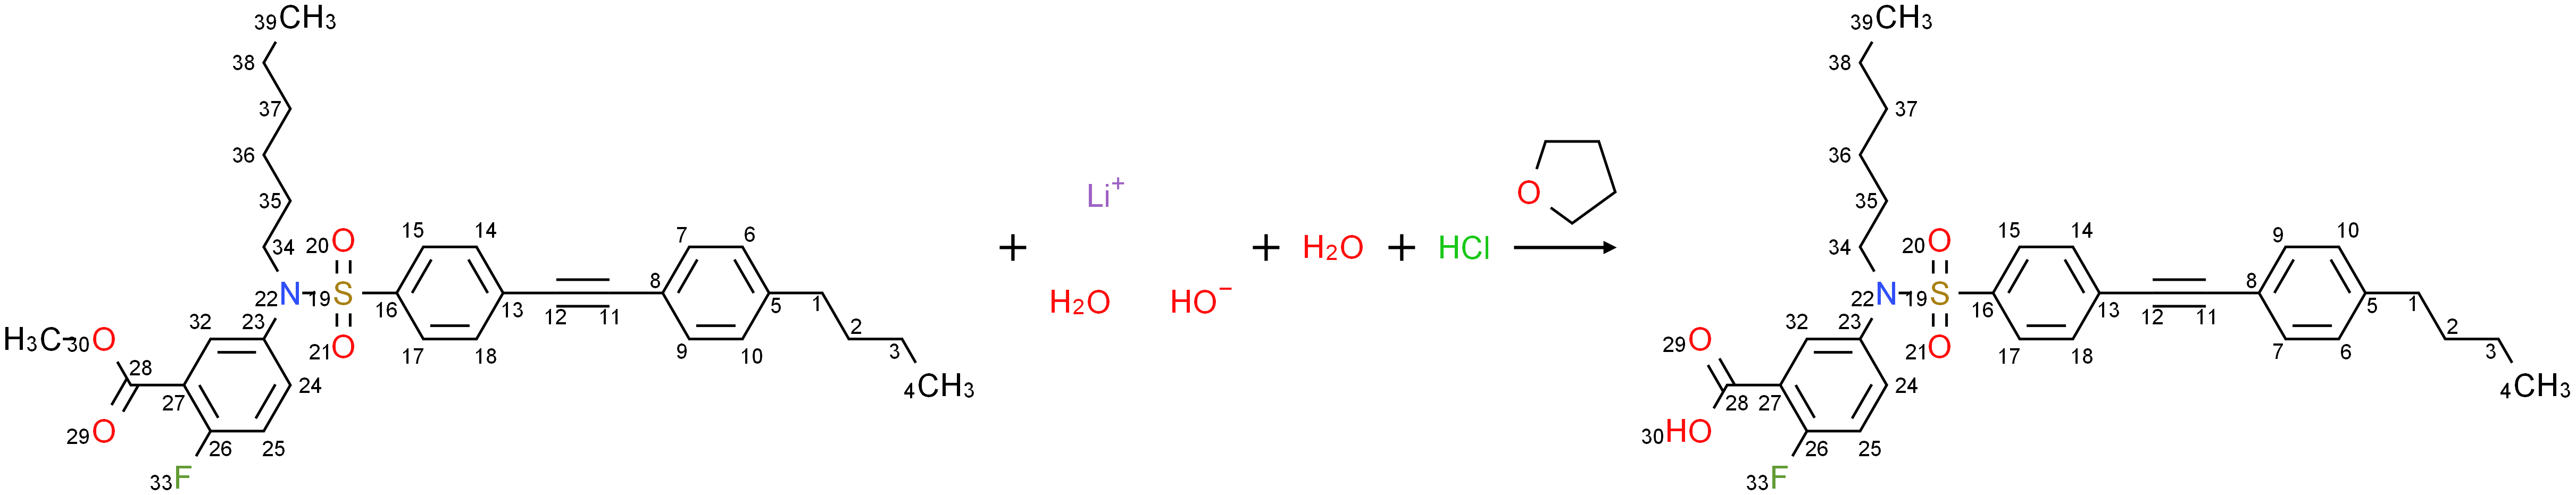

Set size:         280
Patent:           US07947851B2
Reaction_id:      ord-10920b2582104329b40d77d160cb9712
To a solution of methyl 5-[({4-[(4-butylphenyl)ethynyl]phenyl}sulfonyl)(hexyl)amino]-2-fluorobenzoate (207 mg; 0.38 mmol) in anhydrous THF (7 mL) were added lithium hydroxide monohydrate (158 mg; 3.77 mmol) and water (3 mL). The reaction mixture was stirred under MW at 100° C. for 2500 s. Then an aqueous solution of HCl (1N) was added and the mixture extracted with EtOAc (2×50 mL). The combined organic layers were washed with brine, dried over magnesium sulfate and the solvent was removed under reduced pressure to give 185 mg (91.7%) of the title compound as a brown cream. HPLC, Rt: 5.71 min (purity=98.5%). LC/MS, M−(ESI): 534.3. 1H NMR (MeOD) δ: 7.66 (d, J=8.66 Hz, 2H), 7.58 (d, J=8.66 Hz, 3H), 7.46 (d, J=7.91 Hz, 2H), 7.31. (m, 1H), 7.23 (m, 3H), 3.61 (m, 3H), 2.66 (t, J=7.53 Hz, 2H), 1.63 (qt, J=7.34 Hz, 2H), 1.35 (m, 12H), 0.96 (t, J=7.91 Hz, 3H), 0.87 (t, J=6.97 Hz, 3H).


In [10]:
# seconds
print((df.time_unit == 'SECOND').sum())
draw_reaction(df[df.time_unit == 'SECOND'])

In [11]:
# convert time to HOURS

mask = df.time_unit == 'SECOND'
df.loc[mask, 'time_val'] = df.loc[mask, 'time_val'] / 3600

mask = df.time_unit == 'MINUTE'
df.loc[mask, 'time_val'] = df.loc[mask, 'time_val'] / 60

mask = df.time_unit == 'DAY'
df.loc[mask, 'time_val'] = df.loc[mask, 'time_val'] * 24

In [12]:
df.time_val.describe()

count    534242.000000
mean          8.464771
std          19.339936
min           0.000000
25%           1.000000
50%           2.500000
75%           8.000000
max        2160.000000
Name: time_val, dtype: float64

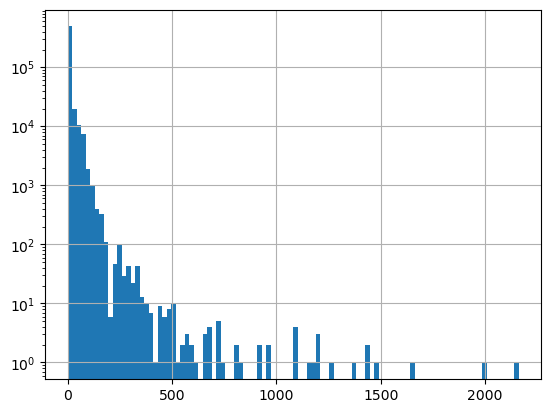

In [13]:
df.time_val.hist(bins=100)
plt.yscale('log')

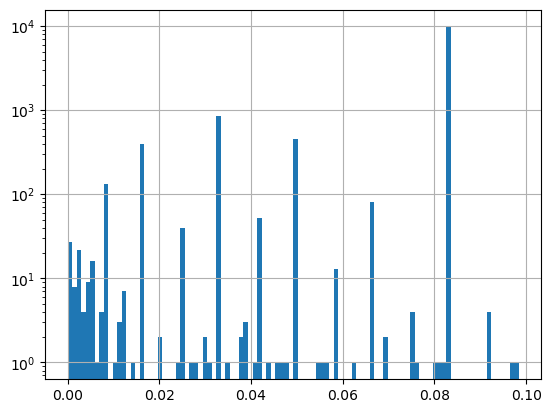

In [14]:
# inspect outliers
df[df.time_val < 0.1].time_val.hist(bins=100)
plt.yscale('log')

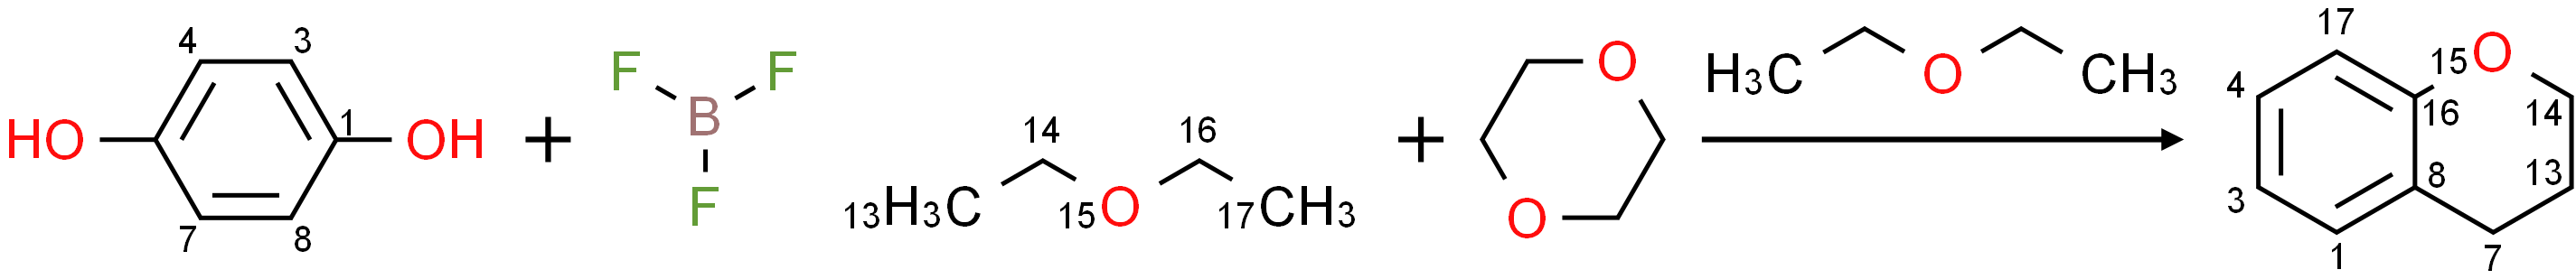

Set size:         8
Patent:           US06242479B1
Reaction_id:      ord-009af41175954de8b17b12067996214f
To a solution of hydroquinone 1 (0.01 mol) and a catalyst, preferably boron trifluoride diethyl etherate (0.016 mol) In an organic solvent, preferably dry dioxane (10 mL), is added vinyl lactone 2 (0.016 mol) in an organic solvent, preferably dry dioxane (5.0 mL) over 1-60 minutes, preferably 60 minutes, at 0-150° C., preferably 110° C., under an inert gas. The reaction mixture is stirred for 0 to 8 hours, preferably 0 hours, at the selected temperature, cooled to room temperature, and diluted with an organic solvent, preferably diethyl ether (200 mL) The reaction mixture is then washed with water (100 mL, 2×50 mL), dried over sodium sulfate (Na2SO4), and solvent is removed under reduced pressure to afford a brown oily residue. The residue is dissolved in alcohol, preferably methanol (30 mL), and the alcohol is then removed under reduced pressure. The brown oily liquid or semisolid

In [15]:
draw_reaction(df[df.time_val == 0.0])

In [16]:
df.tail()

,rxn_smiles,time_unit,time_val,temp_unit,temp_val,temp_control,yield,patent,notes
ord-25cd60edf7274f4e977451fe480d722b,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-c586143a9e88422db39d951976237b09,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-951218b242c246e3ac51a648e4e0c7d9,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."
ord-055170a7c2ee464ba733ada95c7896b8,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."
ord-50ff38288a5a4316959b81c266f6f624,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."


In [17]:
# reset to NaN time == 0.0
mask = df.time_val == 0.0
df.loc[mask, 'time_val'] = np.nan
df.loc[mask, 'time_unit'] = np.nan
df[mask]

,rxn_smiles,time_unit,time_val,temp_unit,temp_val,temp_control,yield,patent,notes
ord-f52e0b391d5149ee916861578ec96bce,[C:1]([O:5][C:6]([N:8]([C:16]1[C:21]([CH3:23])...,NaN,NaN,CELSIUS,-78.0,NaN,NaN,US09309263B2,To a dry flask was added tert-butyl N-tert-but...
ord-77e3cb06d0a7449cb448a45cdf4b3003,[C:1]1([CH:8]=[CH:7]C(O)=[CH:4][CH:3]=1)O.[B]....,NaN,NaN,NaN,NaN,AMBIENT,NaN,US06048891,To a solution of hydroquinone 1 (0.01 mol) and...
ord-91345a02d0c34481b59b0d84a51a4ac6,[C:1]1(O)[CH:6]=[CH:5]C=[CH:3][CH:2]=1.B(F)(F)...,NaN,NaN,NaN,NaN,AMBIENT,NaN,US06048891,To a solution of phenol 4 (0.01 mol) and a cat...
ord-20f38895a7c74d7ea9f6c9b0bd5016c0,[NH2:1][CH:2]1[C:19](=[O:20])[N:4]2[C:5]([C:16...,NaN,NaN,NaN,NaN,AMBIENT,66.199997,US04959495,"A mixture of 7-amino-3-[(1,2,3-thiadiazol-5-yl..."
ord-009af41175954de8b17b12067996214f,[C:1]1([CH:8]=[CH:7]C(O)=[CH:4][CH:3]=1)O.B(F)...,NaN,NaN,NaN,NaN,AMBIENT,NaN,US06242479B1,To a solution of hydroquinone 1 (0.01 mol) and...
ord-a72a83f17a1c4019962f740a6dd9f504,O1CCCC1.[C:6]([O:11][Si](C)(C)C)(=[O:10])[C:7]...,NaN,NaN,NaN,NaN,NaN,NaN,US05250109,A block copolymer of n-butyl methacrylate and ...
ord-4b6a554e34344e9587f0cb61a4875414,[C:1]1([C:32]2[CH:37]=[CH:36][CH:35]=[CH:34][C...,NaN,NaN,NaN,NaN,NaN,86.000000,US08158634B2,A solution of 2-biphenyl-4-yl-8-bromomethyl-1-...
ord-c4e60a15534d41d5931aeb64a309d73b,[C:1]([S:4][CH2:5][CH2:6][NH:7][C:8](=[O:51])[...,NaN,NaN,NaN,NaN,NaN,NaN,US07754455B2,S-acetyl CoA synthetase (acetate thiokinase fr...


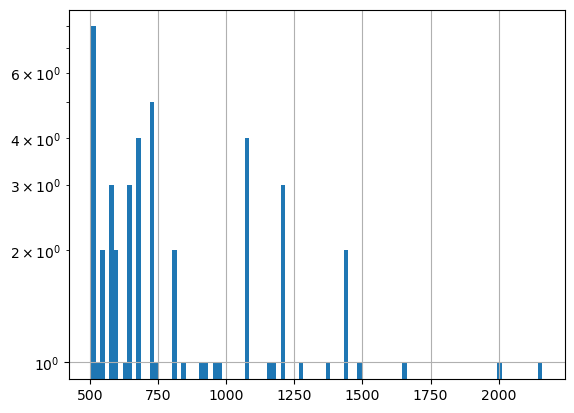

In [18]:
df.loc[df.time_val > 500, 'time_val'].hist(bins=100)
plt.yscale('log')

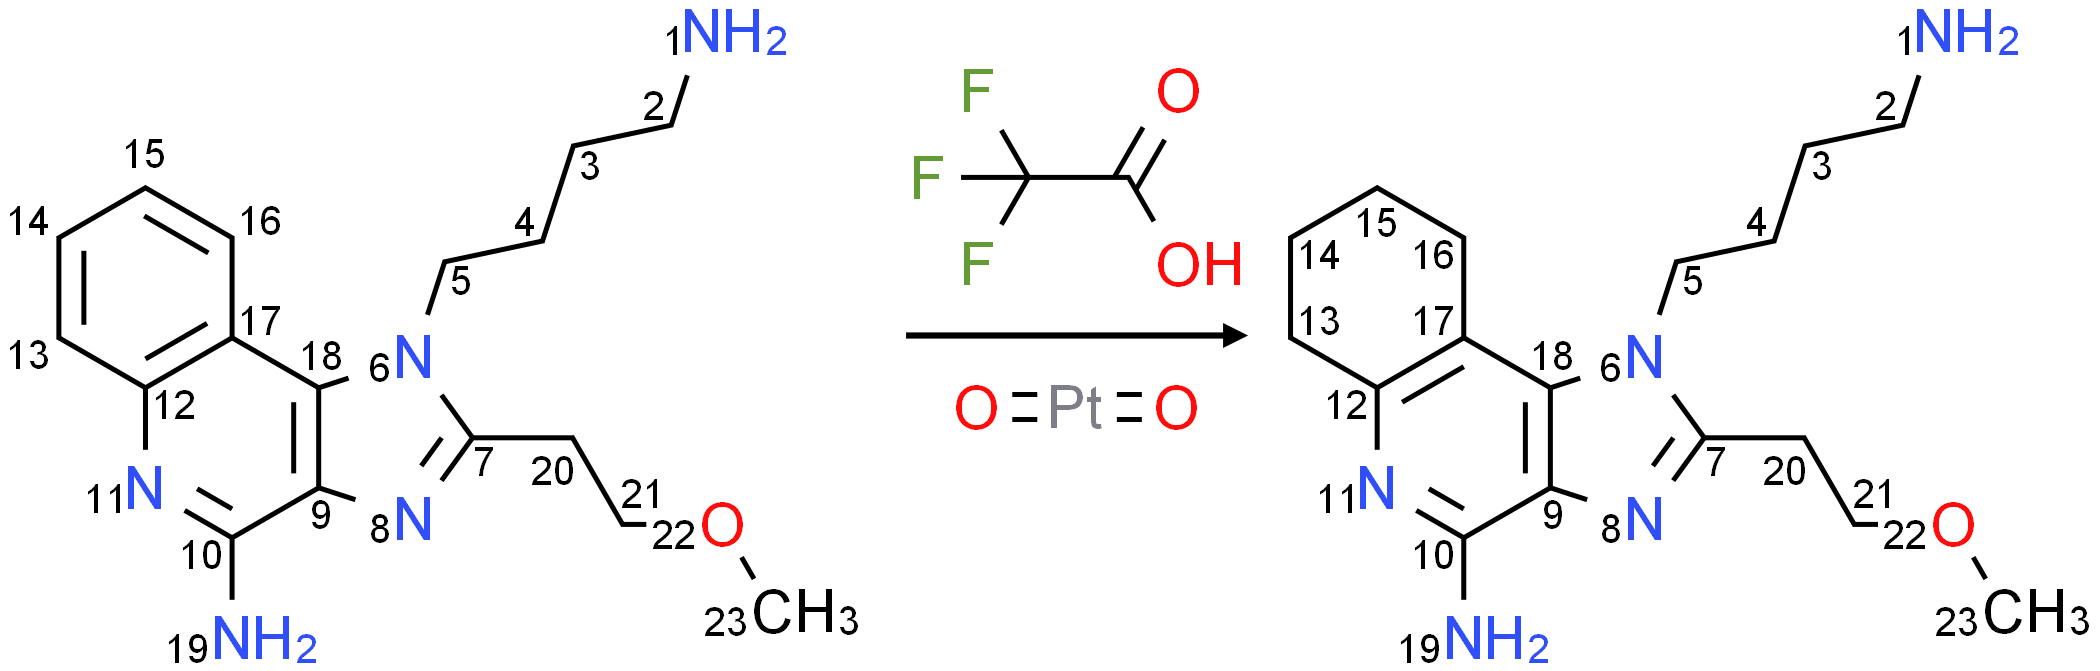

Set size:         54
Patent:           US06756382B2
Reaction_id:      ord-473cb8257b47492889a0b2be9bcb83f0
A catalytic amount of platinum (IV) oxide was added to a solution of 1-(4-aminobutyl)-2-methoxyethyl-1H-imidazo[4,5-c]quinolin-4-amine (7.7 g, 24.5 mmol) in trifluoroacetic acid (250 mL). The reaction mixture was hydrogenated at 50 psi (3.44×105 Pa) on a Parr apparatus. The progress of the reaction was monitored by LC/MS. Additional catalyst was added 7, 11, and 17 days after the start of the reaction. After 25 days the reaction was complete. The reaction mixture was filtered through a layer of Celite® filter aid to remove the catalyst and the filtrate was concentrated under vacuum. The residue was combined with 1 N hydrochloric acid (100 mL) and stirred overnight. The mixture was made basic (pH=11) with ammonium hydroxide and then extracted with dichloromethane (3×300 mL). The extracts were combined and concentrated under vacuum to provide 3.5 g of 1-(4-aminobutyl)-6,7,8,9-tetrah

In [19]:
draw_reaction(df[df.time_val > 500])

In [20]:
df.tail()

,rxn_smiles,time_unit,time_val,temp_unit,temp_val,temp_control,yield,patent,notes
ord-25cd60edf7274f4e977451fe480d722b,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-c586143a9e88422db39d951976237b09,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-951218b242c246e3ac51a648e4e0c7d9,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."
ord-055170a7c2ee464ba733ada95c7896b8,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."
ord-50ff38288a5a4316959b81c266f6f624,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."


In [21]:
# rename time 'column' and drop 'time_unit'
df.rename(columns={'time_val': 'time'}, inplace=True)
df.drop(columns='time_unit', inplace=True)
df

,rxn_smiles,time,temp_unit,temp_val,temp_control,yield,patent,notes
ord-89aff4b1c18042e4bbb1f88ebba96f86,S(Cl)([Cl:3])=O.[CH2:5]([O:13][C:14]1[CH:22]=[...,NaN,NaN,NaN,NaN,NaN,US05723069,A large excess of thionyl chloride was added t...
ord-c218088b16c541088a933a7606f68c4c,[OH:1][C:2]1[CH:10]=[CH:9][C:5]([C:6]([OH:8])=...,24.000000,NaN,NaN,NaN,NaN,US05723069,10 Grams of p-hydroxybenzoic acid and 15 g of ...
ord-d965967cbe69411f9fd760ac1f990dfb,F[C:2]1[CH:10]=[C:9]([OH:11])[CH:8]=[CH:7][C:3...,NaN,NaN,NaN,NaN,NaN,US05723069,p-Acetoxybenzoic acid was prepared in the same...
ord-e8642ae0ecb248809067cd131fde0eed,[NH2:1][C:2]1[CH:17]=[CH:16][C:5]([C:6]([NH:8]...,0.166667,CELSIUS,55.0,NaN,72.300003,US05723075,"4,4'-Diaminobenzanilide (0.658 g, 2.5 mM) was ..."
ord-83e2d9b7b08846c09e3e4e23f2dc9784,[NH2:1][C:2]1[CH:17]=[CH:16][C:5]([C:6]([NH:8]...,0.166667,CELSIUS,55.0,NaN,43.400002,US05723075,"4,4'-Diaminobenzanilide (0.568 g, 2.5 mM) was ..."
...,...,...,...,...,...,...,...,...
ord-25cd60edf7274f4e977451fe480d722b,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-c586143a9e88422db39d951976237b09,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-951218b242c246e3ac51a648e4e0c7d9,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."
ord-055170a7c2ee464ba733ada95c7896b8,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."


## 1.3 Temperature

# Inspect COMPOUNDS dataset

In [712]:
%%time
df = pd.read_pickle(f"{ORD_PATH}/uspto_cmpd.pkl.zst")

CPU times: total: 6.02 s
Wall time: 6.03 s


In [713]:
df_na_vals(df)

trivial       ->      Missing values: 8840707 (89.04%)
name          ->      Missing values: 0 (0.00%)
smiles        ->      Missing values: 451722 (4.55%)
rxn_role      ->      Missing values: 0 (0.00%)


[]

### inspect missing smiles

In [714]:
df[df.smiles.isna()].name.value_counts()

solution                                                                                      37355
ice water                                                                                     29384
solid                                                                                         19056
ice                                                                                           18000
resultant mixture                                                                             10785
                                                                                              ...  
hdyrochloric acid                                                                                 1
C23H24BrClN4O3S                                                                                   1
1-(4-Bromo-benzyl)-4-4-(4-methoxy-benzensulfonyl)-piperidine-4-carboxylic acid ethyl ester        1
3,3'-Dimethyl-1,1'-peroxydicyclohexylamine                                                        1


In [715]:
%%time
rxn = pd.read_pickle(f"{ORD_PATH}/uspto_rxn.pkl.zst")

CPU times: total: 6.44 s
Wall time: 6.46 s


In [716]:
# REACTANT  1
# SOLVENT   3
# CATALYST  4
# WORKUP    5
# PRODUCT   8

df[df.smiles.isna() & (df.name == 'solution')].rxn_role.value_counts()

1    36053
3      993
8      242
4       67
Name: rxn_role, dtype: int64

In [717]:
idx = df[df.smiles.isna() & (df.name == 'solution') & (df.rxn_role == 4)].index

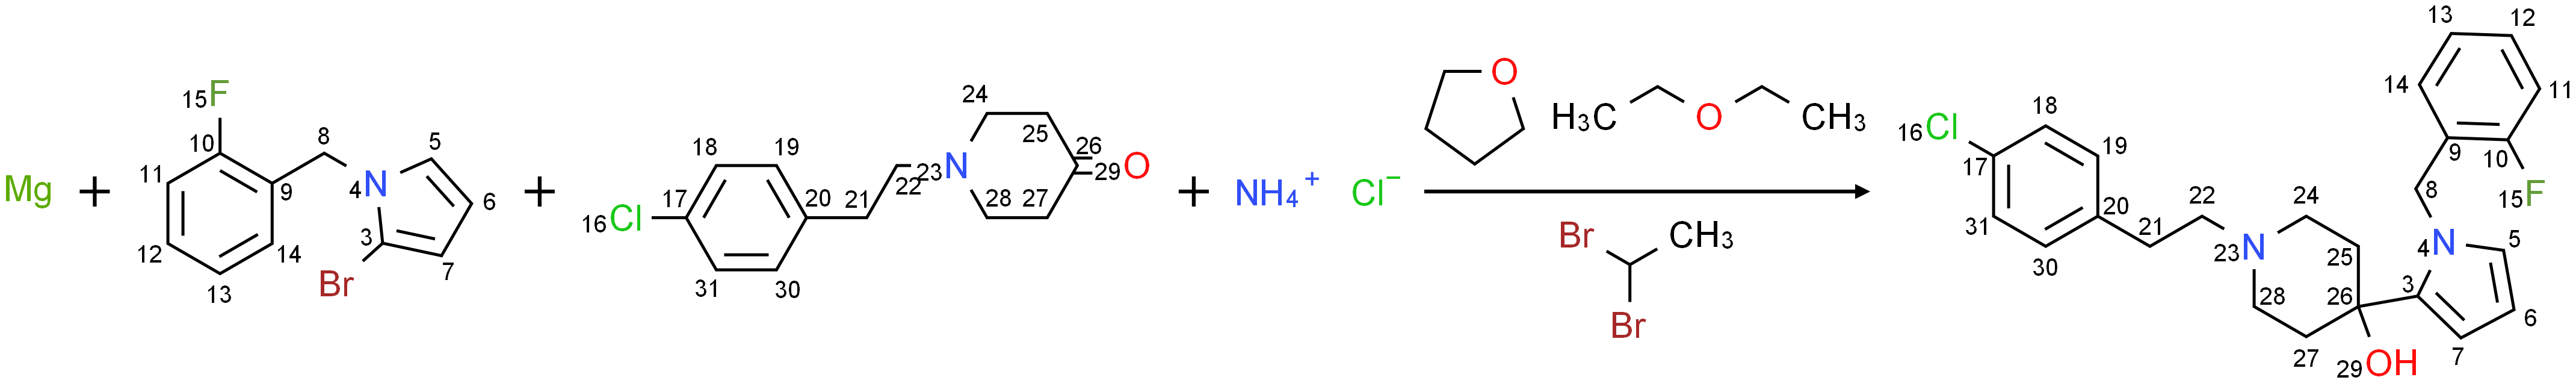

Patent:           US04812450
Reaction_id:      ord-b1020003ca30495cbfde7bff4ef71404
To a suspension of magnesium turnings (1.0 g, 0.04 mole) in 25 ml tetrahydrofuran (THF) and 10 ml ether, was added a few drops of a solution of 2-bromo-1-(2-fluorobenzyl) pyrrole (10.0 g, 0.04 mole) in 30 ml THF. The reaction was initiated with a few drops of dibromoethane and heat, and reflux was maintained by the addition of the bromo compound after stirring at reflux for 30 minutes, the mixture was cooled with an ice-bath; then a solution of 1-(4-chlorophenethyl)-4-piperidone (5.0 g, 0.021 mole) was added. After stirring at ambient temperature for one hour, the mixture was poured into a solution of NH4Cl, then extracted with ether. The ether solution was washed with water, then dried over anhydrous MgSO4. After evaporation of the solvent, the resultant oil, 12 g, was purified by high pressure liquid chromatography (HPLC), using ethyl acetate as the eluent to give 4.5 g of 1-(4-chlorophenethyl)-4-[1-(

In [718]:
draw_reaction(rxn.loc[idx], highlight_text='solution')

### Clean empty smiles
all non chemically-meaningful compounds, e.g. ```'solution', 'solid', 'resultant mixture', 'powder', 'crude material'```, with no smiles can be dropped. It is just parsing error. We keep 'ice water', 'ice', 'water' for the moment as it might indicate solvent or temperature.

In [719]:
empty_smi = df[df.smiles.isna()].name.value_counts()
empty_smi

solution                                                                                      37355
ice water                                                                                     29384
solid                                                                                         19056
ice                                                                                           18000
resultant mixture                                                                             10785
                                                                                              ...  
hdyrochloric acid                                                                                 1
C23H24BrClN4O3S                                                                                   1
1-(4-Bromo-benzyl)-4-4-(4-methoxy-benzensulfonyl)-piperidine-4-carboxylic acid ethyl ester        1
3,3'-Dimethyl-1,1'-peroxydicyclohexylamine                                                        1


In [720]:
q = 0.99
print(empty_smi[empty_smi > empty_smi.quantile(q)].sum() / empty_smi.sum())
token_list = empty_smi[empty_smi > empty_smi.quantile(q)]
token_list

0.6641872656191197


solution                                                               37355
ice water                                                              29384
solid                                                                  19056
ice                                                                    18000
resultant mixture                                                      10785
aqueous solution                                                       10393
TEA                                                                     8281
crude product                                                           7794
hexanes                                                                 7045
oil                                                                     6787
product                                                                 5591
resultant solution                                                      5091
hydrochloride salt                                                      3277

In [721]:
print(np.array2string(token_list.index.values, separator=',', max_line_width=10))

['solution',
 'ice water',
 'solid',
 'ice',
 'resultant mixture',
 'aqueous solution',
 'TEA',
 'crude product',
 'hexanes',
 'oil',
 'product',
 'resultant solution',
 'hydrochloride salt',
 'compound',
 'amine',
 'mixture',
 'acid chloride',
 'ester',
 'alcohol',
 'hexanes ethyl acetate',
 'powder',
 'polyphosphoric acid',
 'Grignard reagent',
 'EtOAc hexanes',
 'petroleum ether',
 'crude material',
 'amide',
 'foam',
 'methyl ester',
 'EtOAc-hexanes',
 'ethyl acetate hexanes',
 'aldehyde',
 '4A',
 'cuprous iodide',
 'stainless steel',
 'material',
 'crystals',
 'crude mixture',
 'liquid',
 'suspension',
 'catalyst',
 'three',
 'anhydride',
 'title compound',
 'resultant suspension',
 'SiO2',
 'Ice water',
 'ketone',
 'N,N-dimethylaminopyridine',
 '( a )',
 'dimethyl acetal',
 'cuprous chloride',
 '( 1 )',
 'steel',
 'residue',
 'xylenes',
 'acid',
 'desired product',
 '( 100 )',
 'diazonium salt',
 'white solid',
 'carboxylic acid',
 'ethyl ester',
 '3A',
 '( 2 )',
 'resin',
 'Tefl

In [722]:
drop_list = [
            'solution',
            # 'ice water',
            'solid',
            # 'ice',
            'resultant mixture',
            # 'aqueous solution',
            # 'TEA',
            'crude product',
            # 'hexanes',
            'oil',
            'product',
            'resultant solution',
            # 'hydrochloride salt',
            'compound',
            # 'amine',
            'mixture',
            # 'acid chloride',
            # 'ester',
            # 'alcohol',
            # 'hexanes ethyl acetate',
            'powder',
            # 'polyphosphoric acid',
            # 'Grignard reagent',
            # 'EtOAc hexanes',
            # 'petroleum ether',
            'crude material',
            # 'amide',
            'foam',
            # 'methyl ester',
            # 'EtOAc-hexanes',
            # 'ethyl acetate hexanes',
            # 'aldehyde',
            '4A',
            # 'cuprous iodide',
            'stainless steel',
            'material',
            'crystals',
            'crude mixture',
            'liquid',
            'suspension',
            'catalyst',
            'three',
            # 'anhydride',
            'title compound',
            'resultant suspension',
            'SiO2',
            # 'Ice water',
            # 'ketone',
            # 'N,N-dimethylaminopyridine',
            '( a )',
            # 'dimethyl acetal',
            # 'cuprous chloride',
            '( 1 )',
            'steel',
            'residue',
            # 'xylenes',
            # 'acid',
            'desired product',
            '( 100 )',
            # 'diazonium salt',
            'white solid',
            # 'carboxylic acid',
            # 'ethyl ester',
            '3A',
            '( 2 )',
            # 'resin',
            'Teflon',
            # 'base',
            'crude residue',
            # 'IMS',
            'II',
            '10',
            '( m )',
            'raw materials',
            # 'stannous chloride dihydrate',
            # 'imine',
            # "N,N'-carbonyldiimidazole",
            'saturated aqueous solution',
            '( 3 )',
            # 'Hexanes',
            # 'stannous chloride',
            'saturated solution',
            # 'solvent',
            '( b )',
            '( 5 )',
            # 'tetrakistriphenylphosphine palladium',
            # 'Mg',
            # 'CuBr',
            '( s )',
            # 'NaIO4',
            '3','1',
            'glass',
            'intermediate',
            # 'cuprous cyanide',
            # 'hydrate',
            # '4-N,N-dimethylaminopyridine',
            # 'peroxide',
            '( 4 )',
            # 'N,N′-carbonyldiimidazole',
            # 'NH4OAc',
            # 'ferric chloride',
            # 'Na',
            # 'ice H2O',
            # 'N-Aryl-benzenesulfonamides',
            # 'water ice',
            # 'hexanes EtOAc',
            '( c )',
            # 'NaH2PO4',
            'reagent',
            'gum',
            '2','20',
            'teflon',
            # 'nitrile',
            # 'alkyne',
            # 'reduced iron',
            # 'oxime',
            # 'monohydrate',
            '( g )',
            '( w )',
            # 'diol',
            'Intermediate 1',
            'starting material',
            # 'fumarate salt',
            'Heterocyclic',
            # 'EtOAc Hexanes',
            # 'stannic chloride',
            # 'nitro',
            # 'mercuric chloride',
            # 'esters',
            '( I )',
            # 'KHCO3',
            # 'LiOH monohydrate',
            # 'polystyrene',
            'yellow solid',
            '( A )',
            'solids',
            # 'amides',
            '15',
            '( 6 )',
            # 'Na2S2O5',
            # 'mercuric acetate',
            'final mixture',
            # 'Ice',
            # 'amino acid',
            '( d )',
            # 'FeCl3',
            # 'ice-salt',
            # 'tetrakis(triphenyl-phosphine)palladium',
            # 'cuprous bromide',
            '50',
            'paraffin',
            # 'epoxide',
            # 'diamine',
            # 'triethylamine-2HF',
            # '1,1-carbonyldiimidazole',
            '( 8 )',
            # 'ethanolic solution',
            # 'mercuric oxide',
            'III',
            'raw material',
            '( 9 )',
            '12',
            'desired material',
            # 'methanolic solution',
            # 'PdCl2dppf',
            # 'peptide',
            'title compounds',
            'salt',
            # 'palladium tetrakistriphenylphosphine',
            '1-L',
            'free base',
            '( 7 )',
            '30',
            # 'diazonium',
            # 'acetate salt',
            # 'diethyl ester',
            '10/1',
            # 'potassium tert.-butylate',
            # 'olefin',
            'Intermediate 2',
            # 'CsCO3',
            'crystal',
            'one',
            # 'cuprous oxide',
            # 'sulfonamide',
            '( 10 )',
            # 'secondary amine',
            'Example 1',
            'two',
            '4',
            'eluent',
            # 'N,N-dicyclohexylcarbodiimide',
            # 'ethyl acetate petroleum ether',
            # 'ceric ammonium nitrate',
            '40',
            # 'Amine',
            'Compound II',
            '( B )',
            # 'CrO3',
            '100',
            # 'thiol',
            # 'cupric acetate',
            'complex',
            # 'petroleum ether ethyl acetate',
            'IV',
            'atmosphere',
            '2-L',
            # 'amines',
            # 'oxide',
            'step-ii',
            'four',
            'E1',
            'desired compound',
            # 'acyl chloride',
            '( II )',
            'crude compound',
            # 'triethyl phosphonoacetate',
            'resultant product',
            'Heterocycles',
            # 'CuSO4.5H2O',
            # 'ethylene ketal',
            'Intermediate 6',
            'crude intermediate',
            # 'ethyl acetate-hexanes',
            # 'acetal',
            'solution A',
            # 'ammonium salt',
            # 'aq. solution',
            # 'oxalate salt',
            # '2B',
            # '5,6-dihydrospiro[benzo[1,2-b:5,4-b′]difuran-3,3′-indol]-2″(1′H)-one',
            # 'Cu',
            # 'alcohols',
            '1h',
            # 'ice hydrochloric acid',
            # 'tertiary amine',
            'desired intermediate',
            '1a',
            # 'heptanes',
            # 'ferrous sulfate',
            # 'Hexanes EtOAc',
            '( 15 )',
            '9',
            # 'cupric chloride',
            'ArH',
            '11',
            # 'pinacol ester',
            '21',
            'title material',
            # 'Pd(Ph3)4',
            'D4',
            'Intermediate 4',
            'amino',
            # 'tetrakistriphenylphosphine palladium(0)',
            'DNA',
            '60',
            # 'diethyl acetal',
            'compound 1',
            # 'SeO2',
            # 'Cu2O',
            # 'industrial methylated spirit',
            'mixed solvent',
            'dihydrobromide',
            # 'tetrakistriphenylphosphine palladium (0)',
            'crude solution',
            # 'amino acids',
            # 'TiCl3',
            'pure product',
            'Intermediate 14',
            'PTFE',
            '2h',
            # 'HClO4',
            'A1',
            '( 12 )',
            # 'Na2HPO4',
            # 'dioxanes',
            # 'sulfonic acid',
            # 'di-TFA',
            'white crystals',
            'E2',
            'trihydrochloride',
            # 'CuCl2',
            'polymer',
            'formula II',
            '1L',
            # 'Boc',
            '13',
            'stock solution',
            # 'CeCl3',
            # 'carboxylic acids',
            # 'H+',
            # 'TBF',
            # 'Ag2O',
            # 'CO3',
            'R3—(CH2)m—NH2',
            '( 11 )',
            # 'Petroleum ether',
            'intermediate 27',
            # 'SO2Cl2',
            '1E',
            '( i )',
            '( C )',
            '25',
            'Solution A',
            'mixed solution',
            'hydrobromide salt',
            '14',
            'resultant residue',
            'Amine-1',
            'Intermediate 12',
            'bromo',
            # 'potassium t-butylate',
            'needles',
            'Intermediate 5',
            # 'enolate',
            # 'carbonyl',
            # 'Pt',
            # 'SnCl2 dihydrate',
            'quartz',
            # 'tetrakis-(triphenylphosphine)palladium',
            'Intermediate 3',
            '5-L',
            'example 1 ( b )',
            '( E )-',
            # 'hydrocarbon',
            # 'ice methanol',
            # 'ferric chloride hexahydrate',
            # 'diacid',
            # 'halogen',
            # 'crude acid',
            '18',
            'same solvent',
            'C2',
            'molar solution',
            'starch',
            '( 20 )',
            '17',
            # 'hydrazone',
            # 'Ti(OEt)4',
            '( ii )',
            # 'K3PO4.3H2O',
            '( 1H )',
            '0C',
            # 'Pd[PPh3]4',
            # 'ferrous chloride tetrahydrate',
            'chloro',
            # 'tetrakis (triphenylphosphine)palladium(0)',
            '( M )',
            # 'alkoxide',
            '1-a',
            # 'pyridinium bromide perbromide',
            '( 14 )',
            # 'magnesium salt',
            '2L',
            'target compound',
            'orange oil',
            'final product',
            'intermediate 1',
            '2A',
            '( III )',
            # 'Cu(I)I',
            # 'FeSO4.7H2O',
            '2C',
            # 'tetrakis triphenylphosphine palladium',
            'Formula III',
            '1/1',
            '200',
            'D1',
            'colorless oil',
            'diazo',
            'formula III',
            # 'PdC',
            # 'Pd--C',
            # 'polyester',
            # 'lactone',
            'VI','5',
            # 'hydrazide',
            # 'Na2SO4.10H2O',
            # 'glycol',
            'Solvent B',
            # 'primary amine',
            # 'NaHB(OAc)3',
            '6',
            '( 13 )',
            'Intermediate 7',
            'buffer solution',
            # 'N-oxide',
            '1A',
            # 'potassium osmate dihydrate',
            '( 18 )',
            '( 16 )',
            # 'halide',
            # 'diester',
            # 'zeolite',
            # 'ice acetone',
            'Intermediate 100',
            # 'hexanes ether',
            # 'carbamates',
            # 'ether-hexane',
            # 'petroleum ether EtOAc',
            'beige solid',
            # 'PdCl2(dppf)-CH2Cl2Adduct',
            # 'Amide',
            # 'sulfuric acid ester',
            # 'PdCl2(dppf)CH2Cl2',
            # 'Hastelloy',
            '( 19 )',
            'yellow oil',
            # 'ammonium sulfide',
            # 'azoisobutyronitrile',
            'Example 1 ( i )',
            # 'butyl ester',
            'final solution',
            '3h',
            'Intermediate 9',
            'syrup',
            '16',
            'compound 5',
            '3R',
            'crude oil',
            '2-N',
            'ion',
            # 'dihydrate',
            'Example 1 ( a )',
            '( E )',
            # 'polyethylene glycol',
            # 'RuCl3',
            # 'dimethyl ester',
            # '2-Me THF',
            'reaction mixture',
            # 'tetrakis(triphenyl-phosphine)palladium(0)',
            # 'Aqueous solution',
            # 'ferrous sulfate heptahydrate',
            'tricyclic bromide',
            # '4-nitrophenylchloroformate',
            '70',
            '5a',
            # 'acyloxyalkyl carbamates',
            'polyol',
            # 'hemihydrate',
            # 'aqueous saturated solution',
            # 'ether hexanes',
            # 'Ba(OH)2',
            # 'dichlorobis(triphenylphosphine) palladium (II)',
            # 'sulfone',
            '( D )',
            # "N,N'-Carbonyldiimidazole",
            # 'ion-exchanged',
            'alkyl',
            '1c',
            # 'ice NaCl',
            # 'enamine',
            # 'dimaleate',
            'off-white solid',
            '3-L',
            # 'EtOAc petroleum ether'
]

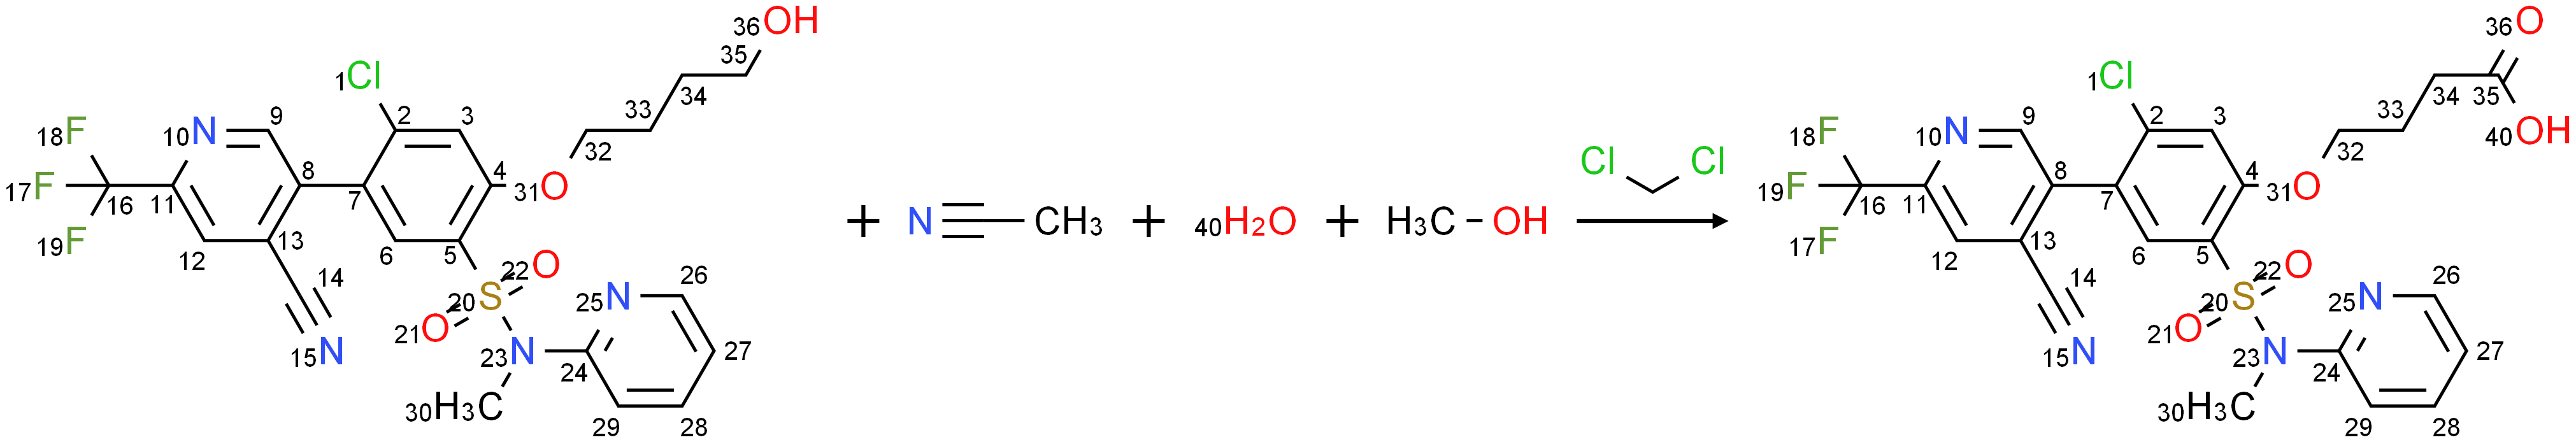

Patent:           US08263588B2
Reaction_id:      ord-648bba1398964d06a248e6a9cac889e4
To 4-chloro-5-(4-cyano-6-trifluoromethyl-pyridin-3-yl)-2-(4-hydroxy-butoxy)-N-methyl-N-pyridin-2-yl-benzenesulfonamide (45 mg, 0.083 mmol) in a mixture of DCM (0.3 mL), acetonitrile (0.3 mL) and water (0.4 mL) was added NaIO4 (54 mg, 0.25 mmol) and RuCl3 (2.7 mg, 0.013 mmol). After stirring at rt for 20 minutes, 0.5 mL of methanol was added. The mixture was stirred for 5 minutes, filtered, and purified by prep. LCMS to afford 4-[5-chloro-4-(4-cyano-6-trifluoromethyl-pyridin-3-yl)-2-(methyl-pyridin-2-yl-sulfamoyl)-phenoxy]-butyric acid 18-1. MS: 555.1 (M+H)+; tR=7.61 min (method 2).


In [730]:
token = 'RuCl3'
idx = df[df.smiles.isna() & (df.name == token)].index
draw_reaction(rxn.loc[idx], highlight_text=token)

In [724]:
drop_list

['solution',
 'solid',
 'resultant mixture',
 'crude product',
 'oil',
 'product',
 'resultant solution',
 'compound',
 'mixture',
 'powder',
 'crude material',
 'foam',
 '4A',
 'stainless steel',
 'material',
 'crystals',
 'crude mixture',
 'liquid',
 'suspension',
 'catalyst',
 'three',
 'title compound',
 'resultant suspension',
 'SiO2',
 '( a )',
 '( 1 )',
 'steel',
 'residue',
 'desired product',
 '( 100 )',
 'white solid',
 '3A',
 '( 2 )',
 'Teflon',
 'crude residue',
 'II',
 '10',
 '( m )',
 'raw materials',
 'saturated aqueous solution',
 '( 3 )',
 'saturated solution',
 '( b )',
 '( 5 )',
 '( s )',
 '3',
 '1',
 'glass',
 'intermediate',
 '( 4 )',
 '( c )',
 'reagent',
 'gum',
 '2',
 '20',
 'teflon',
 '( g )',
 '( w )',
 'Intermediate 1',
 'starting material',
 'Heterocyclic',
 '( I )',
 'yellow solid',
 '( A )',
 'solids',
 '15',
 '( 6 )',
 'final mixture',
 '( d )',
 '50',
 'paraffin',
 '( 8 )',
 'III',
 'raw material',
 '( 9 )',
 '12',
 'desired material',
 'title compounds'

In [725]:
%%time
mask = ~df.name.isin(drop_list)
mask.sum()

CPU times: total: 938 ms
Wall time: 949 ms


9775263

In [726]:
%%time
df = df[mask]

CPU times: total: 734 ms
Wall time: 735 ms


In [727]:
df_na_vals(df)

trivial       ->      Missing values: 8686770 (88.86%)
name          ->      Missing values: 0 (0.00%)
smiles        ->      Missing values: 297790 (3.05%)
rxn_role      ->      Missing values: 0 (0.00%)


[]

In [728]:
# save cleaned version
df.to_pickle(f'{ORD_PATH}/uspto_cmpd.pkl.zst')

Total occurencies: 6


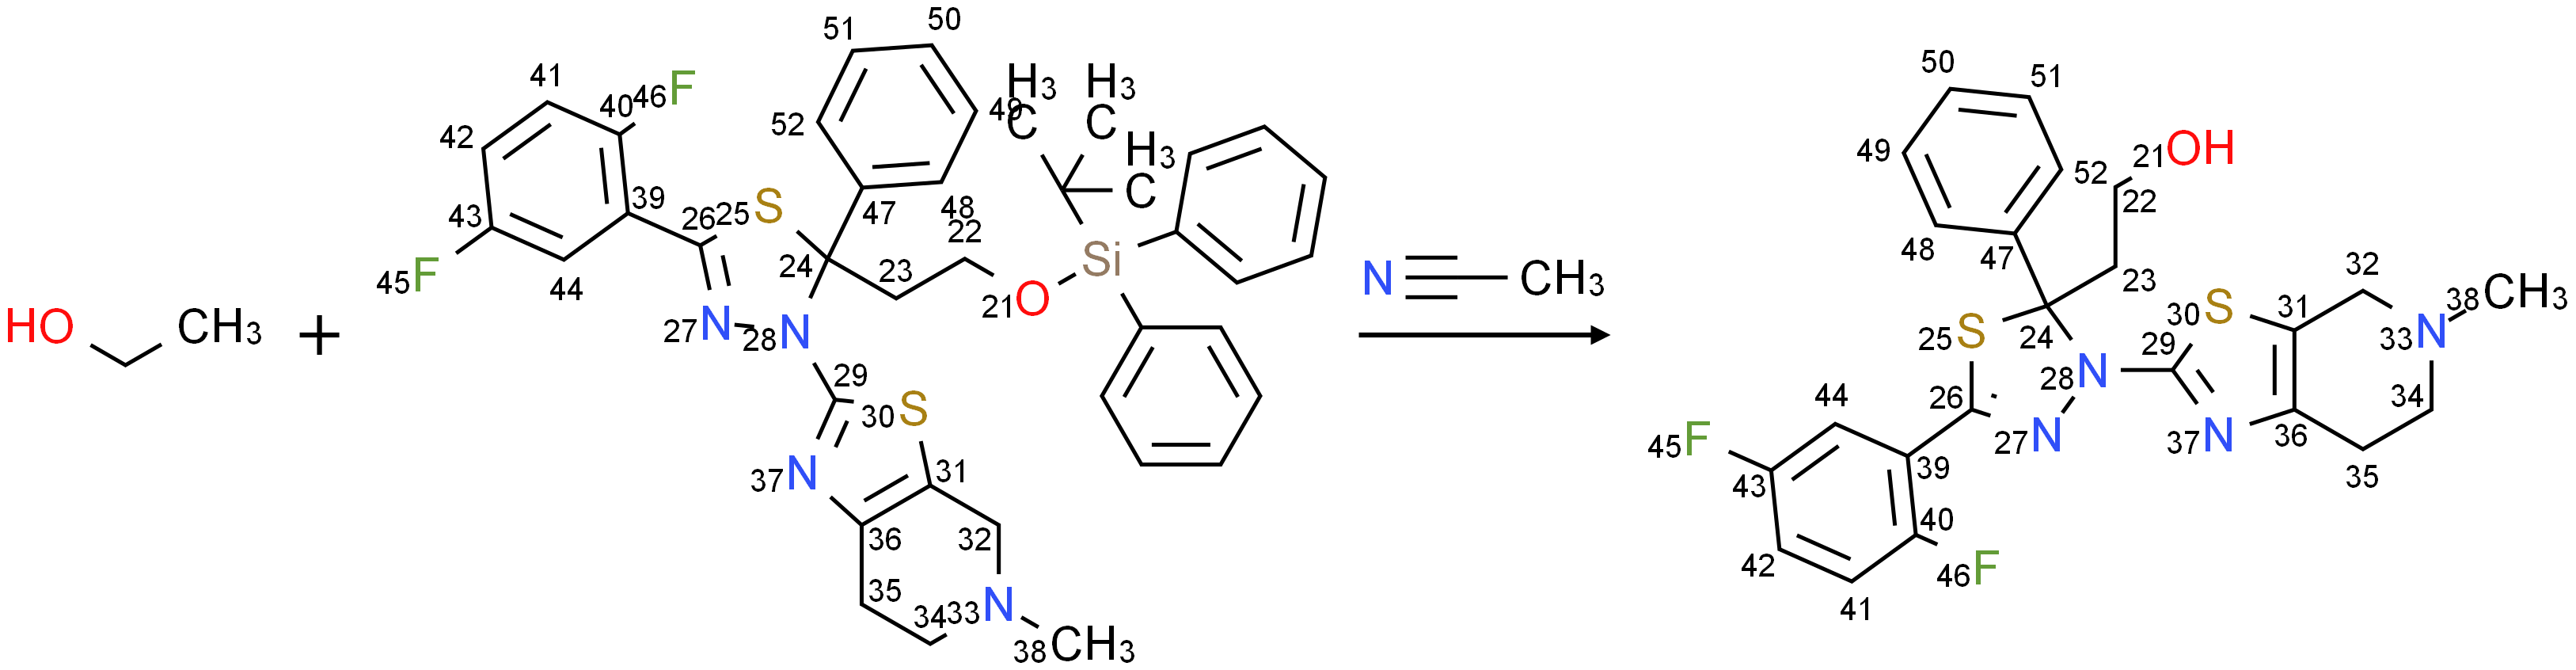

Patent:           US08268871B2
Reaction_id:      ord-99edb586463d4afea72f9388ac8830fc
Preparation of 245-(2,5-difluorophenyl)-3-(5-methyl-4,5,6,7-tetrahydrothiazolo[5,4-c]pyridin-2-yl)-2-phenyl-2,3-dihydro-1,3,4-thiadiazol-2-yl)ethanol: To a solution of 2-(2-(2-(tert-butyldiphenylsilyloxy)ethyl)-5-(2,5-difluorophenyl)-2-phenyl-1,3,4-thiadiazol-3(2H)-yl)-5-methyl-4,5,6,7-tetrahydrothiazolo[5,4-c]pyridine (0.070 g, 0.098 mmol) in 2 mL of anhydrous acetonitrile was added HF-TEA (0.160 mL, 0.99 mmol). The solution was stirred at room temperature for 16 hours then slowly quenched with saturated NaHCO3 (20 mL). The mixture was extracted with EtOAc (3×10 mL) and the combined organic phases were washed with brine (10 mL), dried over Na2SO4 and concentrated in vacuo. The residue was purified by flash column chromatography (0-1% MeOH/DCM) and the residue was dissolved in 2 mL of methanol and treated with 1N HCl/MeOH (2 mL). After stirring for 10 minutes, the solution was concentrated in vacuo. T

In [729]:
#TODO fix 'HF-TEA' token interpreted as 'TEA' only
idx = rxn.notes.str.contains(' HF-TEA')
print("Total occurencies:", idx.sum())
draw_reaction(rxn.loc[idx], highlight_text='HF-TEA')